In [27]:
import torch
import torchvision
import torchvision.transforms as transforms

CIFAR 10을 불러오고 정규화하기

In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(), # PIL Image를 Tensor로 변환하는 Transform. 이미지의 픽셀값을 [0, 255]에서 [0.0, 1.0] 범위로 스케일링한다.
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # transforms.Compose 뒤에는 list of "Transform objects"가 와야 함.
                                                              # transform은 다양한 Data augmetation을 한번에 손쉽게 해주는 기능이다. 

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform) # 얘는 사실상 trainset 변수에 데이터를 저장한 것이 아니라 특정 위치에 데이터가 있고 그걸 불러오는 역할을 하는 객체를 trainset 변수에 저장한 것
                                                                             # testset[0]과 같이 입력하면 특정 데이터를 불러오는 것임.
                                                                             # 다운로드가 필요하다면 download=True로 설정
                                                                             # Train set으로 데이터를 다운 받음
                                                                              
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)      # batch size만큼 데이터를 묶어서 로드, shuffle=True로 데이터 섞음, num_workers=2로 subprocess 사용하여 데이터 로드 
                                                                            # 아예 별도의 메모리 공간을 갖는 '프로세스'를 새로 띄워서(Subprocess) 물리적으로 CPU의 여러 코어를 동시에 사용하는 방식을 택합니다.

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

2


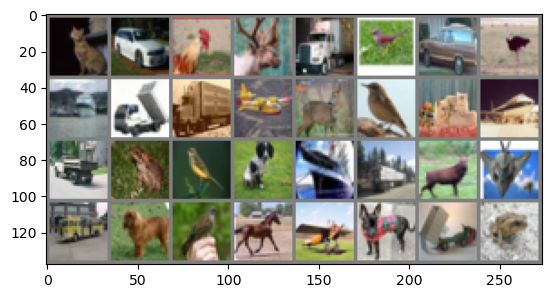

cat   car   bird  deer  truck bird  car   bird  ship  truck truck plane deer  bird  cat   plane truck frog  bird  dog   ship  truck deer  plane truck dog   bird  horse plane dog   truck frog 


In [29]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # Tensor를 numpy 배열로 변환
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # numpy 배열의 차원 순서를 (채널, 높이, 너비)에서 (높이, 너비, 채널)로 변경하여 이미지로 표시
    plt.show()

# trainloader가 어떻게 구성되어있는지 확인
# 일단 하나만 꺼내서 뭉치(batch)에 담아봅니다.
batch = next(iter(testloader))

# 그 뭉치가 몇 개의 덩어리로 되어 있는지 확인!
print(len(batch))


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader) # shuffle=True로 데이터가 섞여 있기 때문에 매번 다른 이미지가 나옴
                             # 객체를 반복할 수 있는 형태로 만들어주는 함수인 iter()를 사용하여 trainloader에서 이터레이터를 생성
                             # 그냥 trainloader을 호출하면 이터레이터가 아니라 DataLoader 객체 자체가 반환되기 때문에, iter() 함수를 사용하여 이터레이터로 변환해야 함
                             # iter를 쓰면 이터레이터가 반환되어 데이터가 담겨 있는 덩어리를 하나씩 꺼낼 수 있게 됨

images, labels = next(dataiter) # 이터레이터에서 다음 덩어리를 꺼내서 images와 labels에 저장



# 이미지 보여주기
imshow(torchvision.utils.make_grid(images)) # 4개의 이미지를 하나의 그리드로 만들어서 보여주는 함수
                                            # make_grid는 여백을 넣도록 설정 되어 있어서 여백이 있음
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))



합성곱 신경망 정의 하기

In [30]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, 5) # 입력 채널 수 3(RGB), 출력 채널 수 6(feature map이 6개), 커널 크기 5(5*5 필터)인 2D convolutional layer
        self.pool = nn.MaxPool2d(2, 2) # 커널 크기 2, 스트라이드 2인 Max pooling layer. 입력을 2x2 영역으로 나누고 각 영역에서 최대값을 출력하여 공간 크기를 절반으로 줄임
        self.conv2 = nn.Conv2d(100, 100, 5) # conv1에서 출력된 6개의 feature map을 입력으로 받아서 16개의 feature map을 출력하는 2D convolutional layer 
        self.fc1 = nn.Linear(100 * 5 * 5, 120) # flatten된 feature map을 입력으로 받아서 120개의 출력을 내놓는 fully connected layer. conv2의 출력이 16개의 feature map이고, 각 feature map의 크기가 5x5이므로, 총 16*5*5개의 입력이 fc1에 들어감
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # 가장 높은 점수의 인덱스를 고르면 됨.
        return x


net = Net()

손실 함수와 optimizer 정의하기

In [31]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Softmax가 내부에서 수행.
                                  # CrossEntropyLoss는 모델의 출력과 실제 레이블 간의 차이를 계산하는 손실 함수
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


신경망 학습하기

In [34]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # enumerate(trainloader, 0)은 trainloader에서 데이터를 하나씩 꺼내면서 인덱스도 함께 반환하는 함수입니다. i는 인덱스, data는 실제 데이터입니다.
                                              # 그냥 trainloader를 호출해도 for문이 돌아감. for문이 알아서 iter해줌.
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels) # 위에서 정의한 cross entropy loss 함수 사용
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 250 == 249:    # print every 250 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 250:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   250] loss: 1.404
[1,   500] loss: 1.405
[1,   750] loss: 1.383
[1,  1000] loss: 1.330
[1,  1250] loss: 1.338
[1,  1500] loss: 1.322
[2,   250] loss: 1.268
[2,   500] loss: 1.243
[2,   750] loss: 1.246
[2,  1000] loss: 1.215
[2,  1250] loss: 1.194
[2,  1500] loss: 1.166
Finished Training


In [33]:
# 모델 저장하기
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)